In [7]:
from matplotlib import pyplot as plt
import numpy as np
import os
from os.path import isdir, isfile
import pandas as pd

from numpy.random import default_rng
from pathlib import Path
import scipy.ndimage as ndimage
import torch
import lampe
import zuko
import torchvision.transforms as T
import torchvision.transforms.functional as F


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import h5py
import numpy as np

from bisect import bisect
from numpy import ndarray as Array
from pathlib import Path
from torch import Tensor, Size
from torch.distributions import Distribution
from torch.utils.data import DataLoader, Dataset, IterableDataset
from tqdm import tqdm
from typing import *

from corner import corner

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
training_path = Path("/home/lwelzel/Documents/git/maldcope/data/TrainingData/")

aux_data = pd.read_csv(training_path / "AuxillaryTable.csv")
spec_data = h5py.File(training_path / 'SpectralData.hdf5')

planet_list = [p for p in spec_data.keys()]

FM_parameters = pd.read_csv(training_path / "Ground Truth Package/FM_Parameter_Table.csv")

para_names = ['planet_radius', 'planet_temp', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
print(FM_parameters.columns)


Index(['Unnamed: 0', 'planet_ID', 'planet_radius', 'planet_temp', 'log_H2O',
       'log_CO2', 'log_CO', 'log_CH4', 'log_NH3'],
      dtype='object')


In [3]:
def to_matrix(SpectralData, id_name="Planet_train"):
    # id is in ascending order
    num = len(SpectralData.keys())
    id_order = np.arange(num)
    # we knew the instrument resolution beforehand
    observed_spectrum = np.zeros((num, 52, 4))
    for idx, x in enumerate(id_order):
        current_id = f'{id_name}{x + 1}'
        wlgrid = SpectralData[current_id]['instrument_wlgrid'][:]
        spectrum = SpectralData[current_id]['instrument_spectrum'][:]
        noise = SpectralData[current_id]['instrument_noise'][:]
        wlwidth = SpectralData[current_id]['instrument_width'][:]
        observed_spectrum[idx, :, :] = np.concatenate(
            [wlgrid[..., np.newaxis], spectrum[..., np.newaxis], noise[..., np.newaxis], wlwidth[..., np.newaxis]],
            axis=-1)
    return observed_spectrum


spec_matrix = to_matrix(spec_data)


(41423, 52, 4)
[0.00076988 0.00087687 0.00077754 0.00058605 0.00064839 0.00040819
 0.00045742 0.00038421 0.00032987 0.00037585 0.00037149 0.00035438
 0.00033483 0.00030161 0.00025313 0.00026408 0.00028865 0.00028427
 0.00029387 0.00023737 0.00018133 0.00016819 0.00025573 0.0002109
 0.00025726 0.00046635 0.00046342 0.00040938 0.00035593 0.00033262
 0.00028828 0.00030791 0.00053423 0.00072947 0.0005874  0.00087755
 0.00077903 0.00056289 0.00052741 0.00047008 0.00036822 0.00032831
 0.0003168  0.00138084 0.001197   0.00061731 0.00022718 0.00031981
 0.00028095 0.00039607 0.00061575 0.00072532]


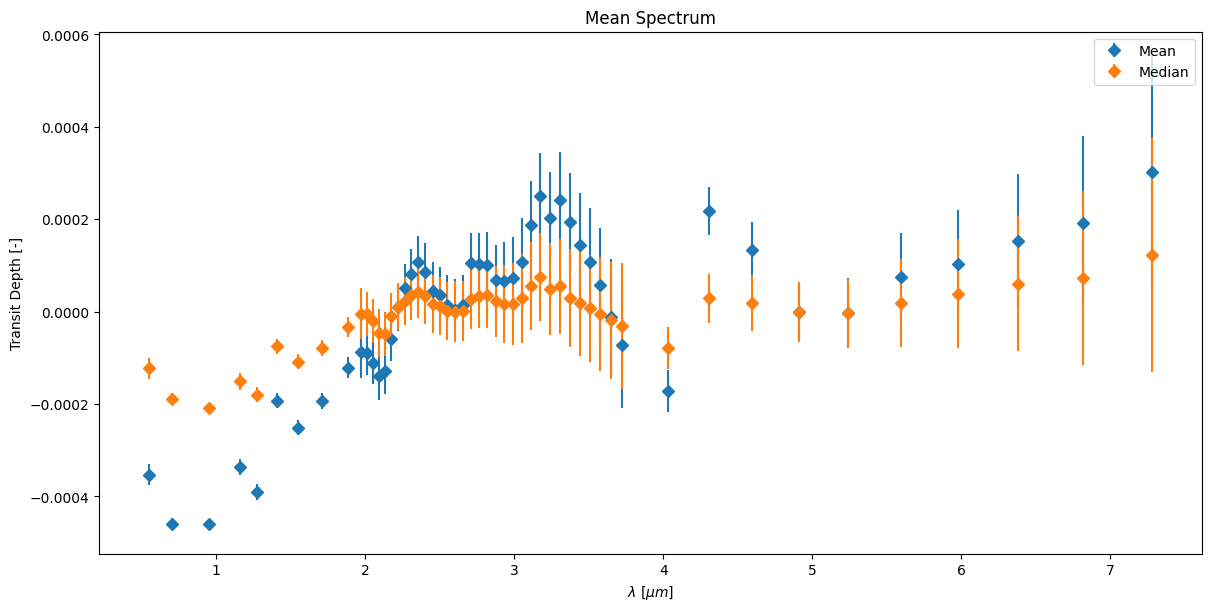

In [9]:
%matplotlib inline
print(spec_matrix.shape)
mean_wl = np.mean(spec_matrix[:, :, 0], axis=0)

ind_mean_spectra = spec_matrix[:, :, 1] - np.mean(spec_matrix[:, :, 1], axis=1).reshape((-1, 1))
mean_spectrum = np.mean(spec_matrix[:, :, 1], axis=0)
median_spectrum = np.median(spec_matrix[:, :, 1], axis=0)
std_spectrum = np.std(ind_mean_spectra, axis=0)

mean_spectrum = np.mean(ind_mean_spectra, axis=0)
median_spectrum = np.median(ind_mean_spectra, axis=0)

ind_mean_noise = np.abs(spec_matrix[:, :, 2] - np.mean(spec_matrix[:, :, 2], axis=1).reshape((-1, 1)))
mean_noise = np.mean(spec_matrix[:, :, 2], axis=0)
median_noise = np.mean(spec_matrix[:, :, 2], axis=0)
std_noise = np.std(ind_mean_noise, axis=0)


fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(12, 6))


ax.errorbar(mean_wl,
            mean_spectrum, #  - np.mean(mean_spectrum),
            yerr=mean_noise,
            # xerr=wlwidth,
            fmt="D",
            label="Mean")

ax.errorbar(mean_wl,
            median_spectrum, #  - np.mean(mean_spectrum),
            yerr=median_noise,
            # xerr=wlwidth,
            fmt="D",
            label="Median")

ax.legend()

ax.set_xlabel(r"$\lambda$ [$\mu m$]")
ax.set_ylabel(r"Transit Depth [-]")
ax.set_title(f"Mean Spectrum")

plt.show()

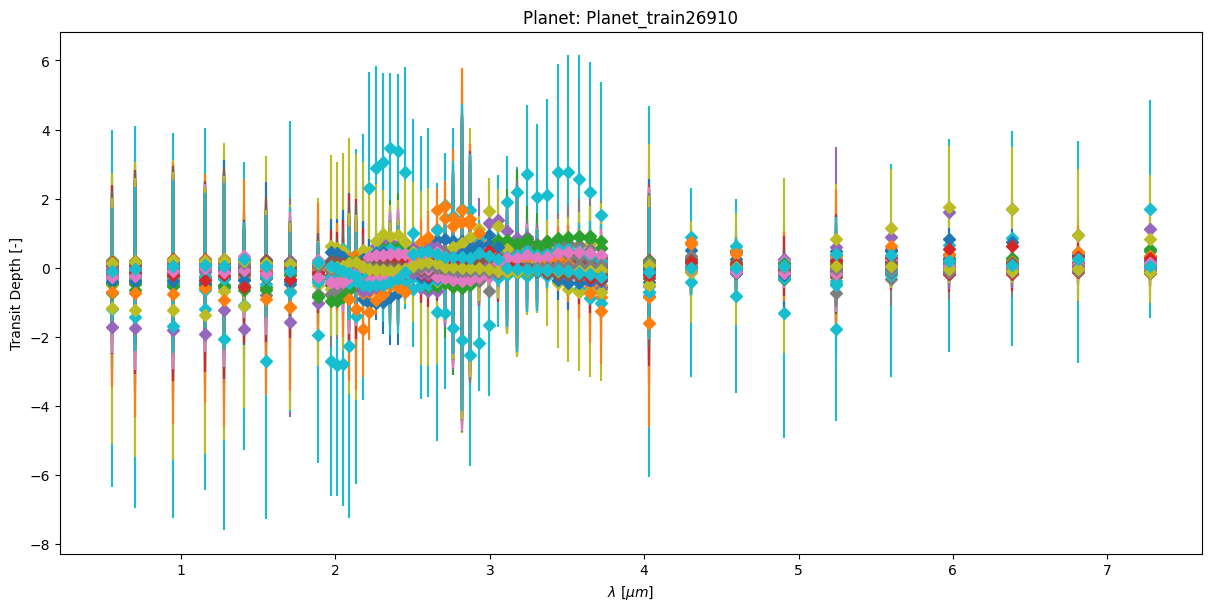

In [25]:
%matplotlib inline

def plot_spectrum(spectra_arr, planet_list, i=None):
    rng = default_rng()

    fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(12, 6))

    for i in rng.integers(0, len(planet_list), 50):
        wlgrid = mean_wl
        spectrum = spectra_arr[i]
        noise = ind_mean_noise[i]
        # wlwidth = spec_dat[planet_list[i]]['instrument_width'][:]



        # ax.errorbar(wlgrid,
        #             spectrum - mean_spectrum,
        #             yerr=np.abs(noise - mean_noise),
        #             # xerr=wlwidth,
        #             fmt="D")

        ax.errorbar(wlgrid,
                    (spectrum - median_spectrum) /  (std_spectrum),
                    yerr=(np.abs(noise - median_spectrum)) / (std_noise),
                    # xerr=wlwidth,
                    fmt="D")



    ax.set_xlabel(r"$\lambda$ [$\mu m$]")
    ax.set_ylabel(r"Transit Depth [-]")
    ax.set_title(f"Planet: {planet_list[i]}")

    plt.show()

plot_spectrum(ind_mean_spectra, planet_list)

52


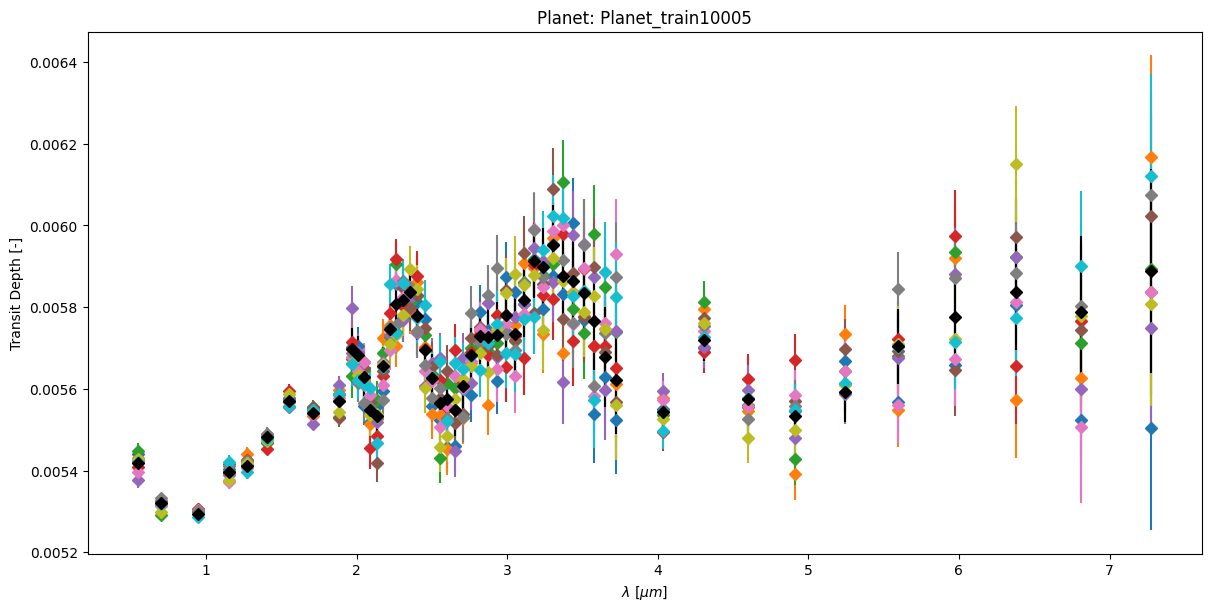

In [22]:
def noisy(x: Tensor) -> Tensor:
    return torch.normal(mean=x[:, 0], std=x[:, 1]).reshape((-1, 52))

%matplotlib inline

def plot_noisy_spectrum(spec_dat, planet_list, i=None):
    rng = default_rng()

    fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(12, 6))

    print(len(spec_dat[planet_list[0]]['instrument_wlgrid'][:]))

    i = int(rng.integers(0, len(planet_list), 1))

    wlgrid = spec_dat[planet_list[i]]['instrument_wlgrid'][:]
    spectrum = spec_dat[planet_list[i]]['instrument_spectrum'][:]
    noise = spec_dat[planet_list[i]]['instrument_noise'][:]
    wlwidth = spec_dat[planet_list[i]]['instrument_width'][:]

    for i in range(10):

        ax.errorbar(wlgrid,
                    torch.normal(mean=torch.tensor(spectrum), std=torch.tensor(noise)),
                    yerr=noise,
                    # xerr=wlwidth,
                    fmt="D")

    ax.errorbar(wlgrid,
        spectrum,
        yerr=noise,
        # xerr=wlwidth,
        fmt="D",
                color="black", ecolor="black")

    ax.set_xlabel(r"$\lambda$ [$\mu m$]")
    ax.set_ylabel(r"Transit Depth [-]")
    ax.set_title(f"Planet: {planet_list[i]}")

    plt.show()

plot_noisy_spectrum(spec_data, planet_list)

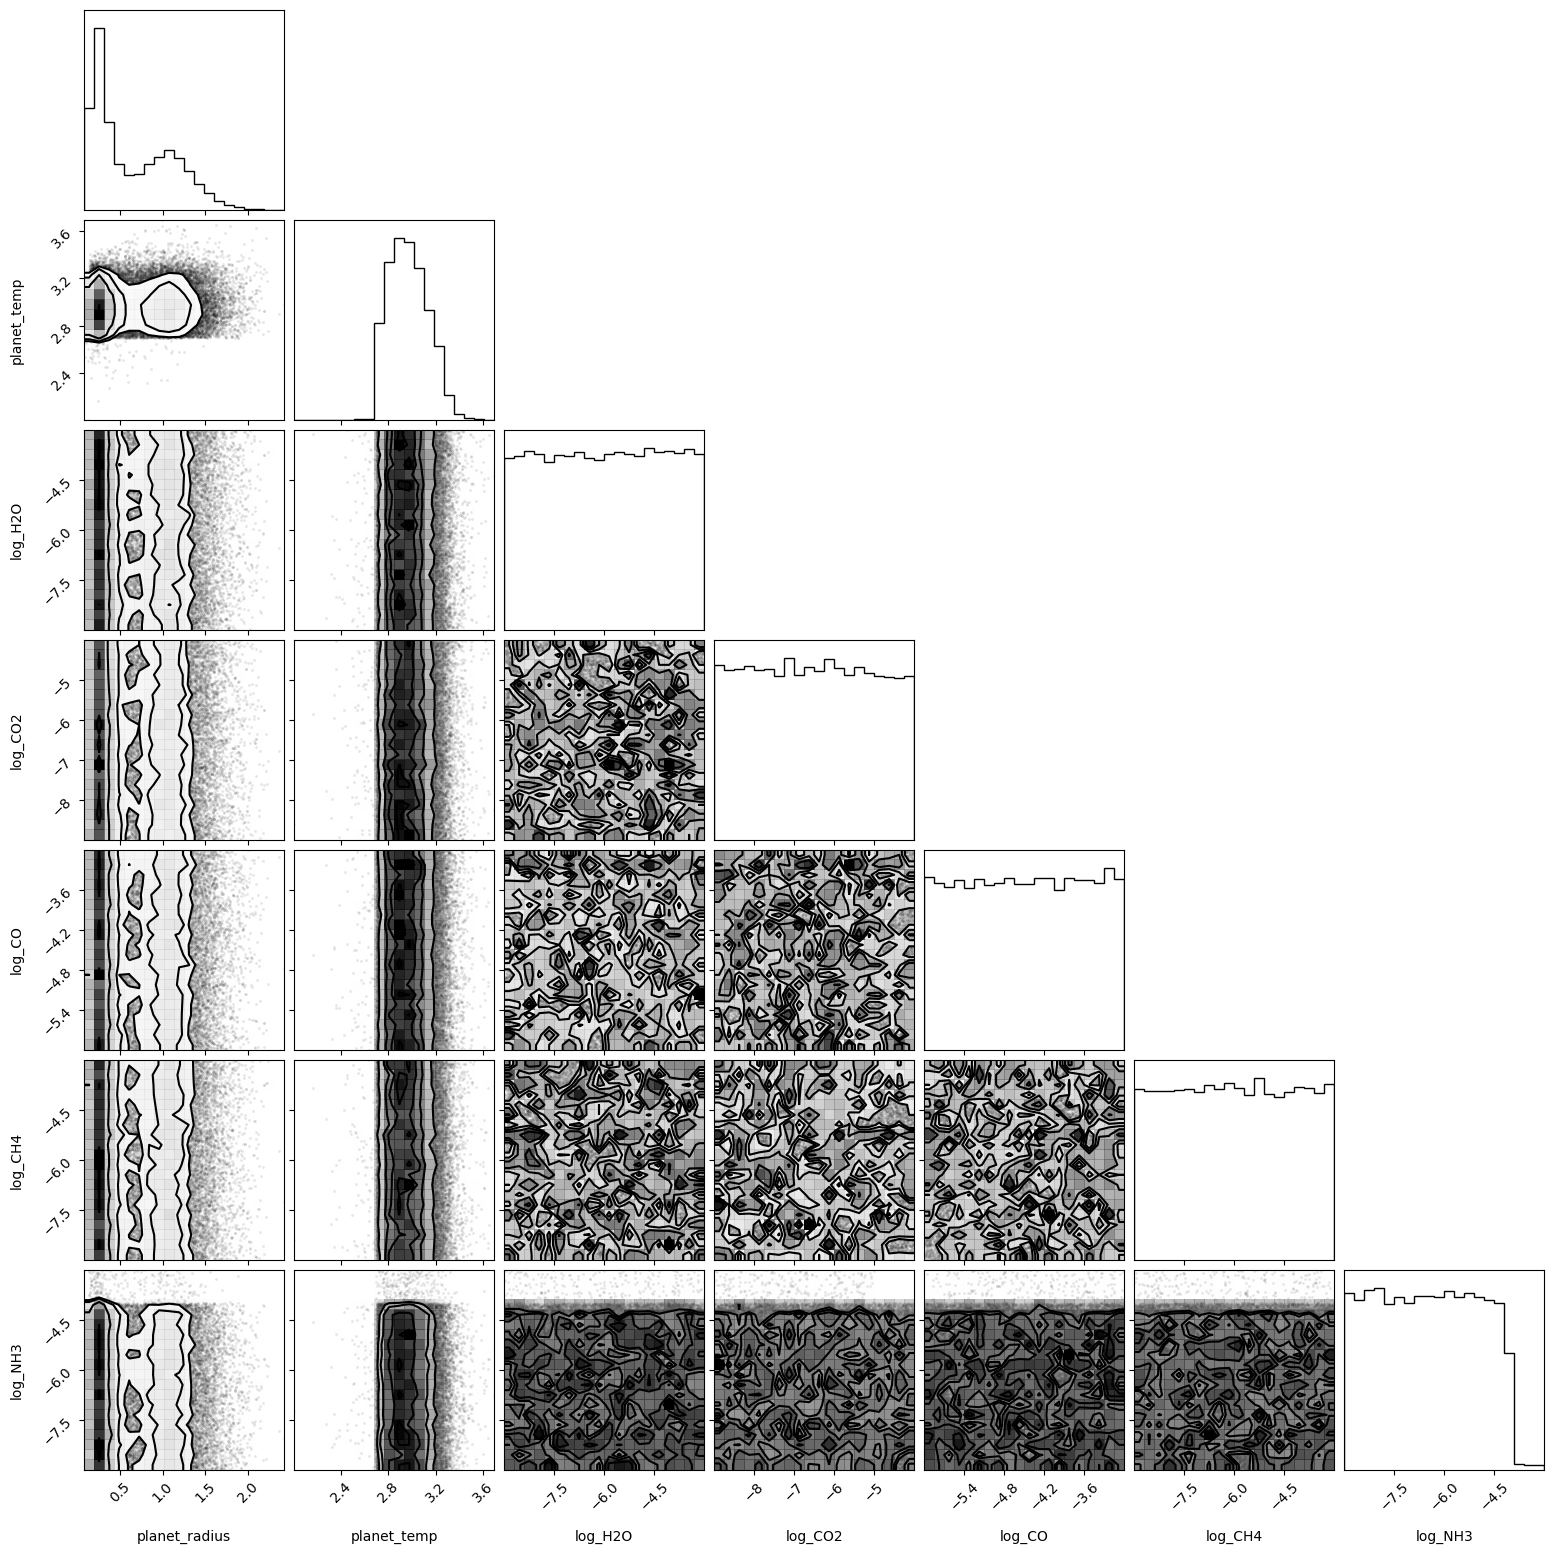

In [34]:
%matplotlib inline

#
# fig = corner(
#     ind_mean_spectra,
#
# )
#
# fig.savefig("/home/lwelzel/Documents/git/maldcope/spectrum_corr.png", dpi=300)

cdata = FM_parameters[para_names].to_numpy()

cdata[:, 1] = np.log10(cdata[:, 1])

fig = corner(
    cdata,
    labels=para_names,
)

fig.savefig("/home/lwelzel/Documents/git/maldcope/training_data_corner.png", dpi=300)

Preprocessing the data using PCA...


IndexError: too many indices for tensor of dimension 1

In [18]:
# TEST DATA

test_path = Path("/home/lwelzel/Documents/git/maldcope/data/TestData/")

test_aux_data = pd.read_csv(test_path / "AuxillaryTable.csv")
test_spec_data = h5py.File(test_path / 'SpectralData.hdf5')

test_planet_list = [p for p in test_spec_data.keys()]

print(len(test_planet_list))

test_spec_matrix = to_matrix(test_spec_data, id_name="Planet_public")


685


(41423, 52, 4)


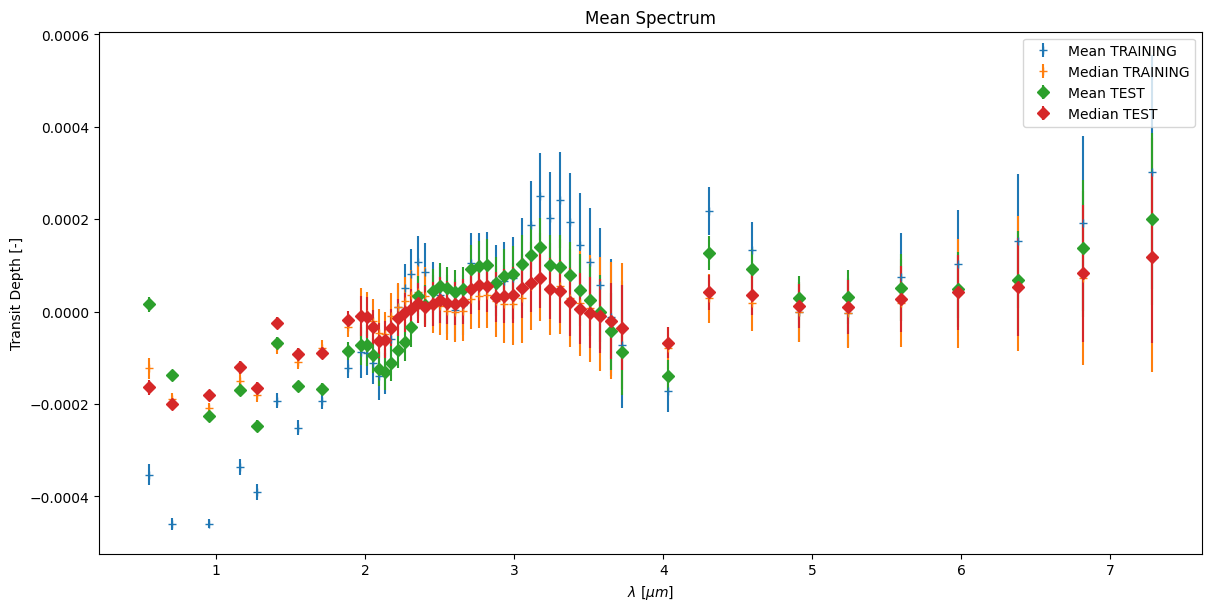

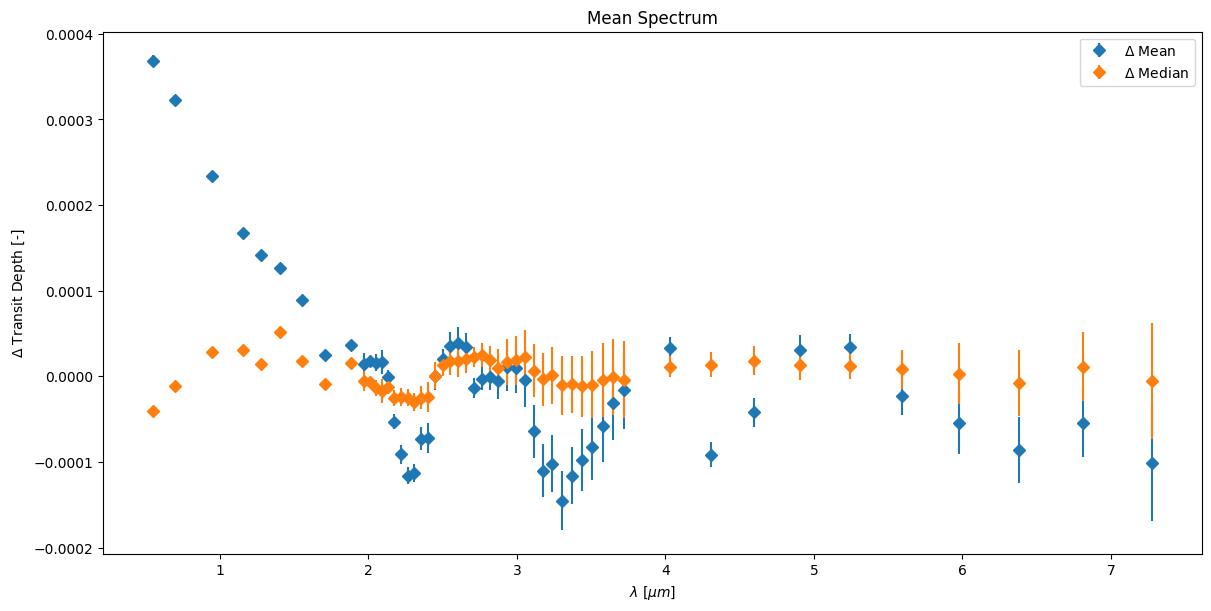

In [20]:
%matplotlib inline
print(spec_matrix.shape)
test_mean_wl = np.mean(test_spec_matrix[:, :, 0], axis=0)

test_ind_mean_spectra = test_spec_matrix[:, :, 1] - np.mean(test_spec_matrix[:, :, 1], axis=1).reshape((-1, 1))
test_mean_spectrum = np.mean(test_spec_matrix[:, :, 1], axis=0)
test_median_spectrum = np.median(test_spec_matrix[:, :, 1], axis=0)

test_mean_spectrum = np.mean(test_ind_mean_spectra, axis=0)
test_median_spectrum = np.median(test_ind_mean_spectra, axis=0)

test_ind_mean_noise = np.abs(test_spec_matrix[:, :, 2] - np.mean(test_spec_matrix[:, :, 2], axis=1).reshape((-1, 1)))
test_mean_noise = np.mean(test_spec_matrix[:, :, 2], axis=0)
test_median_noise = np.mean(test_spec_matrix[:, :, 2], axis=0)

fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(12, 6))


ax.errorbar(mean_wl,
            mean_spectrum, #  - np.mean(mean_spectrum),
            yerr=mean_noise,
            # xerr=wlwidth,
            fmt="+",
            label="Mean TRAINING")

ax.errorbar(mean_wl,
            median_spectrum, #  - np.mean(mean_spectrum),
            yerr=median_noise,
            # xerr=wlwidth,
            fmt="+",
            label="Median TRAINING")

ax.errorbar(test_mean_wl,
            test_mean_spectrum, #  - np.mean(mean_spectrum),
            yerr=test_mean_noise,
            # xerr=wlwidth,
            fmt="D",
            label="Mean TEST")

ax.errorbar(test_mean_wl,
            test_median_spectrum, #  - np.mean(mean_spectrum),
            yerr=test_median_noise,
            # xerr=wlwidth,
            fmt="D",
            label="Median TEST")

ax.legend()

ax.set_xlabel(r"$\lambda$ [$\mu m$]")
ax.set_ylabel(r"Transit Depth [-]")
ax.set_title(f"Mean Spectrum")

plt.show()

fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(12, 6))

ax.errorbar(test_mean_wl,
            test_mean_spectrum - mean_spectrum, #  - np.mean(mean_spectrum),
            yerr=np.abs(test_mean_noise - mean_noise),
            # xerr=wlwidth,
            fmt="D",
            label=r"$\Delta$ Mean")

ax.errorbar(test_mean_wl,
            test_median_spectrum- median_spectrum, #  - np.mean(mean_spectrum),
            yerr=np.abs(test_median_noise - median_noise),
            # xerr=wlwidth,
            fmt="D",
            label=r"$\Delta$ Median")

ax.legend()

ax.set_xlabel(r"$\lambda$ [$\mu m$]")
ax.set_ylabel(r"$\Delta$ Transit Depth [-]")
ax.set_title(f"Mean Spectrum")

plt.show()

In [36]:
# TEST DATA COMPETITION OUTPUT
# competition_output_path = Path("/home/lwelzel/Documents/git/maldcope/data/TrainingData/Ground Truth Package/Tracedata.hdf5")
competition_output_path = Path("/home/lwelzel/Documents/git/maldcope/data/TestData/RT_submission.hdf5")
trace_data = h5py.File(competition_output_path)

trace_planet_list = [p for p in trace_data.keys()]
# para_names = ['planet_radius', 'planet_temp', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']

print(trace_planet_list[:3])



['Planet_0', 'Planet_1', 'Planet_10']


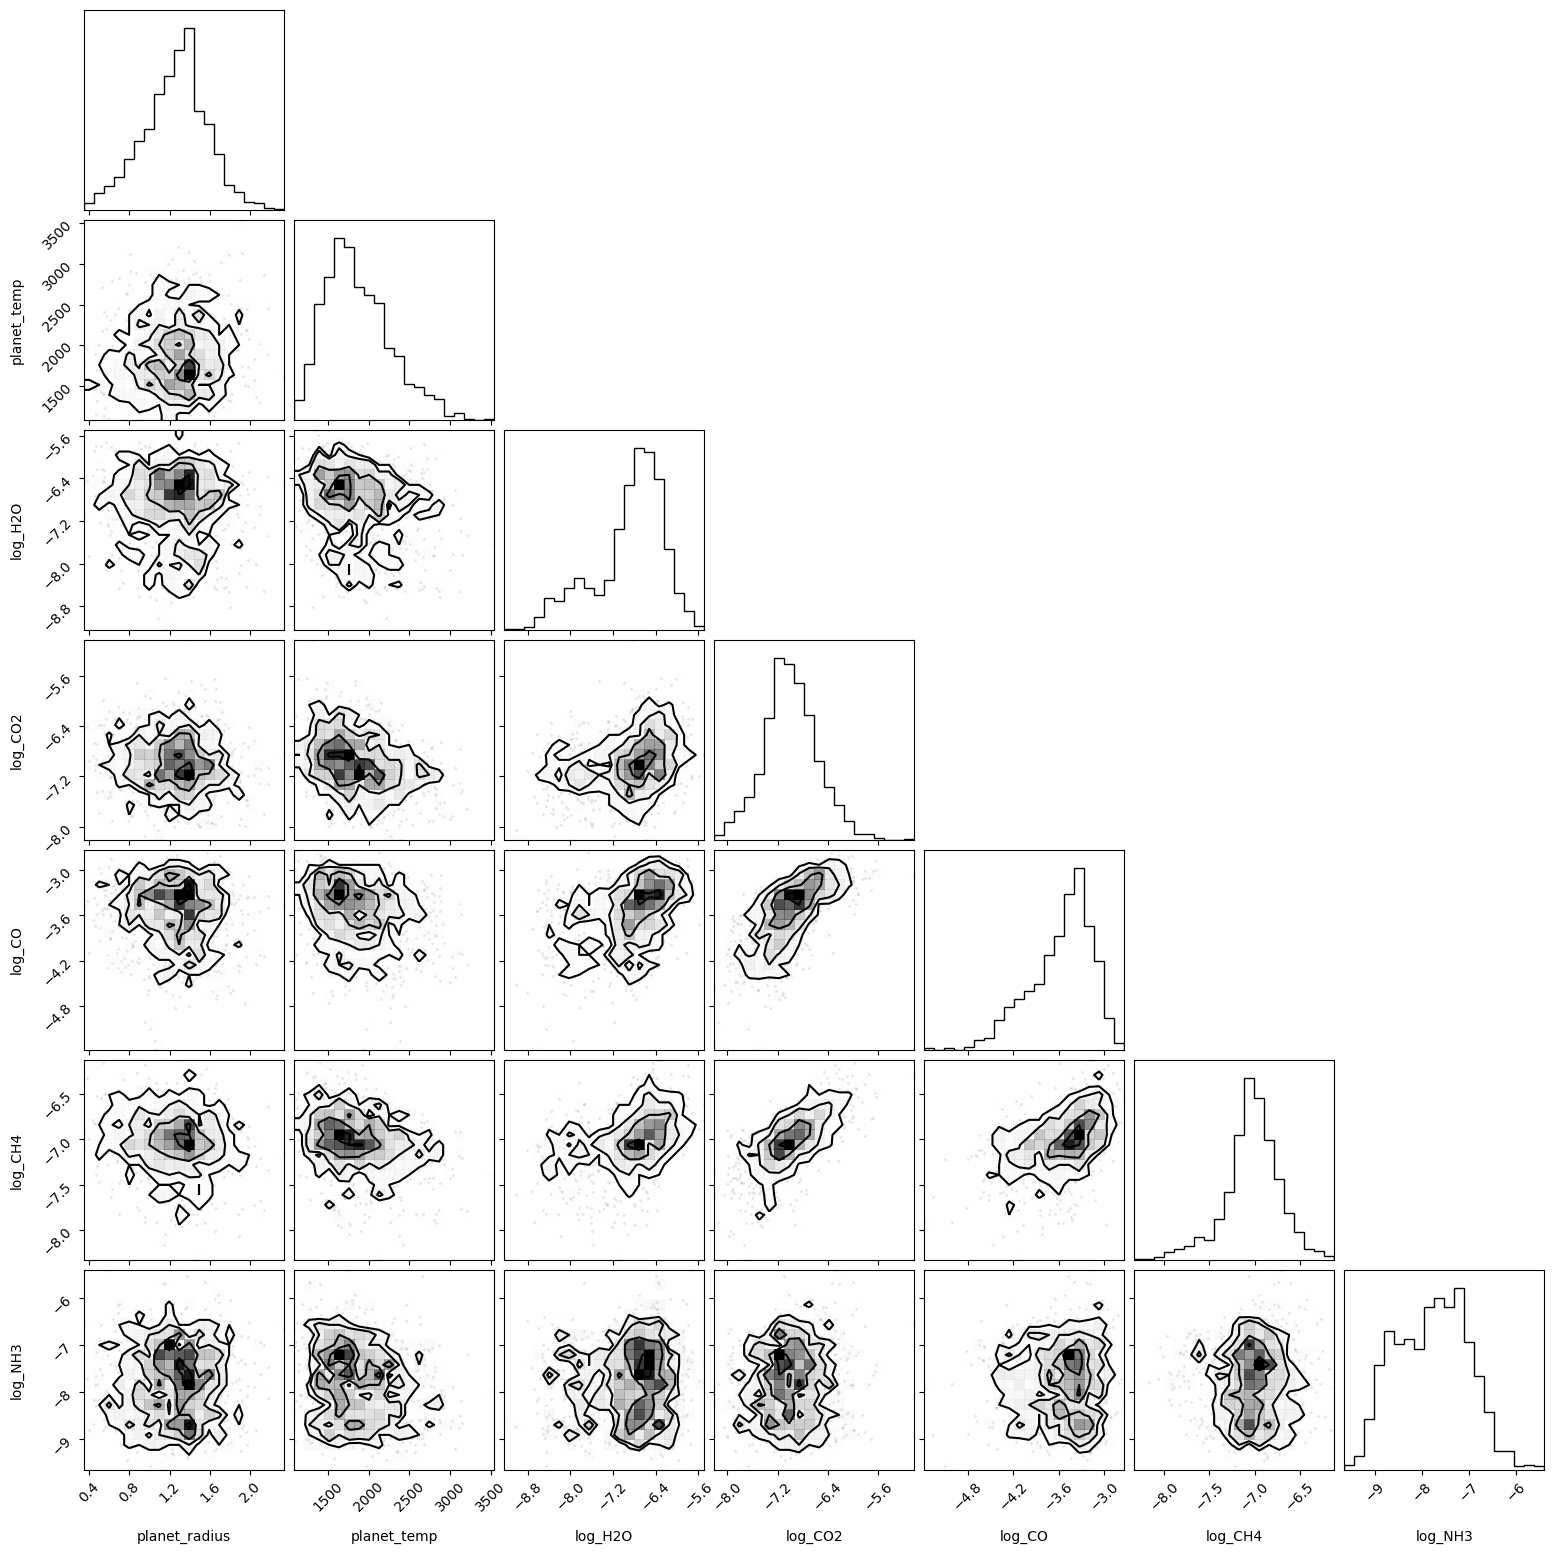

In [37]:
rng = default_rng()

valid = False

while not valid:
    rand_i = rng.integers(len(trace_planet_list))

    rtrace = trace_data[trace_planet_list[rand_i]]['tracedata']
    shape = rtrace.shape

    if len(shape)>0:
        valid = True



fig = corner(
    rtrace[:],
    labels=para_names
)

plt.show()

In [8]:
valid_path = Path("/home/lwelzel/Documents/git/maldcope/data/TrainingData/valid_chain_data.hdf5")
valid_trace_data = h5py.File(valid_path)
valid_planet_list = [p for p in valid_trace_data.keys()]
%matplotlib inline

# key = f"Planet_train{idx+1}"
#
# theta, x = pair
#
# grp = valid_chain_file.create_group(key)
# pl_id = grp.attrs['ID'] = idx
# tracedata = grp.create_dataset('tracedata', data=trace_data[key]['tracedata'])
# weights = grp.create_dataset('weights', data=trace_data[key]['weights'])
# spec_group = grp.create_dataset('spectrum', data=spec_matrix[i])
#
# aux = grp.create_dataset('aux_data', data=aux_data[aux_data_names].iloc[idx].to_numpy())
#
# theta_prime = grp.create_dataset('theta', data=FM_parameters[theta_names].iloc[idx].to_numpy())
# assert np.all(theta_prime == theta.reshape((1, 7)))
# x_data = grp.create_dataset('x', data=x.reshape((-1, 52)))
#
# x_star, x_prime_star = torch.tensor(x[:, 0].reshape((1, 1, -1)), dtype=torch.float), torch.tensor(x[:, 2].reshape((1, -1)), dtype=torch.float)
#
# with torch.no_grad():
#     theta_star = estimator.flow(x_star.cuda(), x_prime_star.cuda()).sample((512,)).reshape((-1, 7)).cpu().numpy()
#
# tracedata_model = grp.create_dataset('tracedata_model', data=theta_star)

min_len = 100000
empties = 0

lens = np.zeros(len(valid_planet_list))

for i, p in enumerate(valid_planet_list):
    print(p)
    print(valid_trace_data[p].keys())
    try:
        l = len(valid_trace_data[p]["weights"][:])
    except KeyError:
        empties += 1

    lens[i] = l

    # min_len = np.minimum(min_len, l)

print(np.quantile(lens, [0.01, 0.04, 0.16, 0.5, 0.84, 0.96, 0.99]))
print(np.max(lens), np.min(lens))
print(empties)
# print(min_len)


rng = default_rng()

rand_i = rng.integers(len(valid_planet_list))

Planet_train1
<KeysViewHDF5 ['aux_data', 'spectrum', 'theta', 'tracedata', 'weights', 'x']>
Planet_train10
<KeysViewHDF5 ['aux_data', 'spectrum', 'theta', 'tracedata', 'weights', 'x']>
Planet_train100
<KeysViewHDF5 ['aux_data', 'spectrum', 'theta', 'tracedata', 'weights', 'x']>
Planet_train1000
<KeysViewHDF5 ['aux_data', 'spectrum', 'theta', 'tracedata', 'weights', 'x']>
Planet_train1001
<KeysViewHDF5 ['aux_data', 'spectrum', 'theta', 'tracedata', 'weights', 'x']>
Planet_train1002
<KeysViewHDF5 ['aux_data', 'spectrum', 'theta', 'tracedata', 'weights', 'x']>
Planet_train1003
<KeysViewHDF5 ['aux_data', 'spectrum', 'theta', 'tracedata', 'weights', 'x']>
Planet_train1004
<KeysViewHDF5 ['aux_data', 'spectrum', 'theta', 'tracedata', 'weights', 'x']>
Planet_train1007
<KeysViewHDF5 ['aux_data', 'spectrum', 'theta', 'tracedata', 'weights', 'x']>
Planet_train1008
<KeysViewHDF5 ['aux_data', 'spectrum', 'theta', 'tracedata', 'weights', 'x']>
Planet_train101
<KeysViewHDF5 ['aux_data', 'spectrum', '

In [16]:
%matplotlib inline

# print(valid_planet_list)

LABELS, LOWER, UPPER = zip(*[
    [        r'${\rm R_{P}}$', -1e2,   1e2],  # planet_radius
    [        r'${\rm T_{P}}$', -1e2,   1e2],  # planet_temp
    [r'$\log X_{\rm H_{2}O}$', -1e2,   1e2],  # log_H2O
    [r'$\log X_{\rm CO_{2}}$', -1e2,   1e2],  # log_CO2
    [    r'$\log X_{\rm CO}$', -1e2,   1e2],  # log_CO
    [r'$\log X_{\rm CH_{4}}$', -1e2,   1e2],  # log_CH4
    [r'$\log X_{\rm NH_{3}}$', -1e2,   1e2],  # log_NH3
])

rand_i = rng.integers(len(valid_planet_list))
# key = f"Planet_train{rand_i+1}"
key = valid_planet_list[rand_i]

print(type(valid_trace_data[key]["tracedata"]))
print(type(valid_trace_data[key]["weights"]))

print(valid_trace_data[key]["tracedata"])

corner(
    valid_trace_data[key]["tracedata"][:],
    weights=valid_trace_data[key]["weights"][:],
    labels=LABELS,
)


KeyError: 'Unable to open object (bad object header version number)'